In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
!wget --trust-server-names -L "https://goo.gl/8hY5ER"

--2025-02-02 13:15:36--  https://goo.gl/8hY5ER
Resolving goo.gl (goo.gl)... 74.125.137.100, 74.125.137.113, 74.125.137.101, ...
Connecting to goo.gl (goo.gl)|74.125.137.100|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz [following]
--2025-02-02 13:15:36--  https://zenodo.org/record/1203745/files/UrbanSound8K.tar.gz
Resolving zenodo.org (zenodo.org)... 188.185.48.194, 188.185.45.92, 188.185.43.25, ...
Connecting to zenodo.org (zenodo.org)|188.185.48.194|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/1203745/files/UrbanSound8K.tar.gz [following]
--2025-02-02 13:15:37--  https://zenodo.org/records/1203745/files/UrbanSound8K.tar.gz
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 6023741708 (5.6G) [application/octet-stream]
Saving to: ‘UrbanSound8K.tar.gz’

UrbanSound8K.tar.gz 100%[=============

In [9]:
!tar -xvzf UrbanSound8K.tar.gz

Streaming output truncated to the last 5000 lines.
UrbanSound8K/audio/fold4/17480-2-0-6.wav
UrbanSound8K/audio/fold4/17480-2-0-9.wav
UrbanSound8K/audio/fold4/175904-2-0-11.wav
UrbanSound8K/audio/fold4/175904-2-0-24.wav
UrbanSound8K/audio/fold4/176003-1-0-0.wav
UrbanSound8K/audio/fold4/176638-5-0-0.wav
UrbanSound8K/audio/fold4/177756-2-0-10.wav
UrbanSound8K/audio/fold4/177756-2-0-4.wav
UrbanSound8K/audio/fold4/177756-2-0-5.wav
UrbanSound8K/audio/fold4/177756-2-0-7.wav
UrbanSound8K/audio/fold4/179862-1-0-0.wav
UrbanSound8K/audio/fold4/180977-3-1-1.wav
UrbanSound8K/audio/fold4/180977-3-1-5.wav
UrbanSound8K/audio/fold4/183989-3-1-21.wav
UrbanSound8K/audio/fold4/183989-3-1-23.wav
UrbanSound8K/audio/fold4/185709-0-0-0.wav
UrbanSound8K/audio/fold4/185709-0-0-1.wav
UrbanSound8K/audio/fold4/185709-0-0-6.wav
UrbanSound8K/audio/fold4/185709-0-0-7.wav
UrbanSound8K/audio/fold4/185909-2-0-102.wav
UrbanSound8K/audio/fold4/185909-2-0-13.wav
UrbanSound8K/audio/fold4/185909-2-0-17.wav
UrbanSound8K/audio

In [36]:
import os
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [37]:
class SoundDataset(Dataset):
    def __init__(self, csv_path, audio_root, window_type='hann', max_duration=4):
        self.metadata = pd.read_csv(csv_path)
        self.audio_root = audio_root
        self.window_type = window_type
        self.sample_rate = 22050
        self.n_fft = 2048
        self.hop = 512
        self.max_frames = int((max_duration * self.sample_rate - self.n_fft) / self.hop) + 1

        self.window_fn = {
            'hann': hann_window,
            'hamming': hamming_window,
            'rectangular': rectangular_window
        }[window_type.lower()]

    def __len__(self):
        return len(self.metadata)

    def _load_audio(self, path):
        return torch.randn(int(4 * self.sample_rate))  # Simulated audio waveform

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        audio_path = os.path.join(self.audio_root, f'fold{row.fold}', row.slice_file_name)

        waveform = self._load_audio(audio_path)
        waveform = waveform / torch.max(torch.abs(waveform))

        spec = stft(waveform, self.window_fn, self.n_fft, self.hop)
        spec_db = 20 * torch.log10(spec + 1e-12)

        if spec_db.shape[1] < self.max_frames:
            spec_db = torch.nn.functional.pad(spec_db, (0, self.max_frames - spec_db.shape[1]))
        else:
            spec_db = spec_db[:, :self.max_frames]

        return spec_db.unsqueeze(0), row.classID

In [38]:
def hann_window(length):
    return 0.5 - 0.5 * torch.cos(torch.linspace(0, 2 * torch.pi, length))

def hamming_window(length):
    return 0.54 - 0.46 * torch.cos(torch.linspace(0, 2 * torch.pi, length))

def rectangular_window(length):
    return torch.ones(length)

def stft(waveform, window_fn, n_fft=2048, hop=512):
    signal = waveform.contiguous().squeeze()
    pad_amount = (n_fft - (signal.numel() % hop)) % hop
    padded = torch.nn.functional.pad(signal, (n_fft // 2, n_fft // 2 + pad_amount))
    frames = padded.unfold(0, n_fft, hop)
    window = window_fn(n_fft).to(signal.device)
    windowed_frames = frames * window
    spectrogram = torch.fft.rfft(windowed_frames, dim=1, norm='forward').abs()
    return spectrogram.mT.contiguous()

In [39]:
def spectrogram():
    # Generate test signal
    sample_rate = 22050
    t = torch.linspace(0, 4, 4*sample_rate)
    test_audio = torch.sin(2*np.pi*440*t)  # 440Hz sine wave

    windows = [
        ('Hann', hann_window),
        ('Hamming', hamming_window),
        ('Rectangular', rectangular_window)
    ]

    plt.figure(figsize=(12, 8))
    for i, (name, window_fn) in enumerate(windows, 1):
        spec = stft(test_audio, window_fn)
        spec_db = 20 * torch.log10(spec + 1e-12)

        plt.subplot(3, 1, i)
        plt.imshow(spec_db, aspect='auto', origin='lower')
        plt.title(f"{name} Window Spectrogram")
        plt.colorbar(label='dB')

    plt.tight_layout()
    plt.show()
    plt.close()

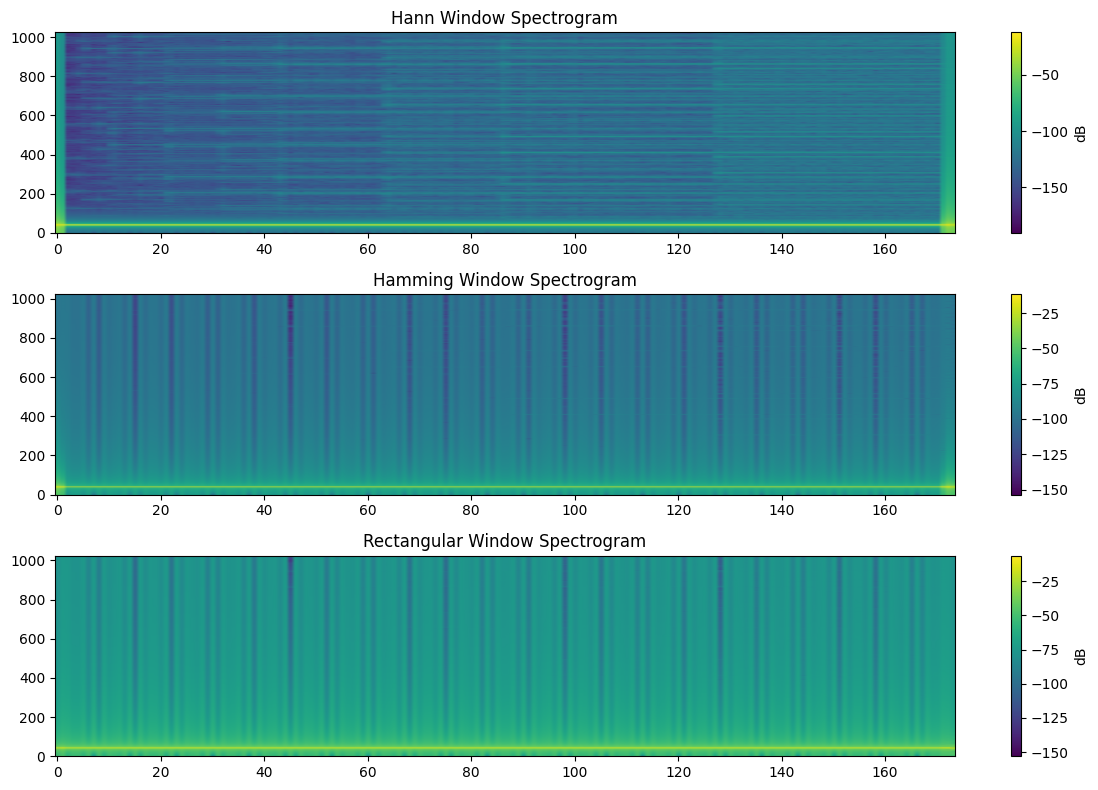

In [40]:
spectrogram()

In [41]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d((4, 4)), nn.Flatten(),
            nn.Linear(64*4*4, 128), nn.ReLU(), nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.layers(x)

In [34]:
def train(window_type):
    batch_size = 32
    num_epochs = 10
    lr = 0.001

    dataset = SoundDataset('/content/UrbanSound8K/metadata/UrbanSound8K.csv', '/content/UrbanSound8K/audio', window_type)
    train_size = int(0.8 * len(dataset))
    test_size = len(dataset) - train_size
    train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=4, pin_memory=True)

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scaler = torch.cuda.amp.GradScaler()

    for epoch in range(num_epochs):
        model.train()
        for specs, labels in train_loader:
            specs, labels = specs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.cuda.amp.autocast():
                outputs = model(specs)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for specs, labels in test_loader:
                specs, labels = specs.to(device), labels.to(device)
                outputs = model(specs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        print(f'Epoch {epoch+1}/{num_epochs} - Val Accuracy: {100*correct/total:.2f}%')

    return 100 * correct / total

In [35]:
choices=['hann', 'hamming', 'rectangular']
for choice in choices:
  final_acc = train(choice)
  print(f'\nFinal accuracy with {choice} window: {final_acc:.2f}%')

Epoch 1/10 - Val Accuracy: 9.79%
Epoch 2/10 - Val Accuracy: 9.79%
Epoch 3/10 - Val Accuracy: 10.65%
Epoch 4/10 - Val Accuracy: 10.65%
Epoch 5/10 - Val Accuracy: 10.65%
Epoch 6/10 - Val Accuracy: 10.65%
Epoch 7/10 - Val Accuracy: 10.88%
Epoch 8/10 - Val Accuracy: 10.65%
Epoch 9/10 - Val Accuracy: 9.79%
Epoch 10/10 - Val Accuracy: 9.79%

Final accuracy with hann window: 9.79%
Epoch 1/10 - Val Accuracy: 11.91%
Epoch 2/10 - Val Accuracy: 10.88%
Epoch 3/10 - Val Accuracy: 11.28%
Epoch 4/10 - Val Accuracy: 10.88%
Epoch 5/10 - Val Accuracy: 10.70%
Epoch 6/10 - Val Accuracy: 11.91%
Epoch 7/10 - Val Accuracy: 10.88%
Epoch 8/10 - Val Accuracy: 11.62%
Epoch 9/10 - Val Accuracy: 10.70%
Epoch 10/10 - Val Accuracy: 10.70%

Final accuracy with hamming window: 10.70%
Epoch 1/10 - Val Accuracy: 10.02%
Epoch 2/10 - Val Accuracy: 11.16%
Epoch 3/10 - Val Accuracy: 11.16%
Epoch 4/10 - Val Accuracy: 11.16%
Epoch 5/10 - Val Accuracy: 11.16%
Epoch 6/10 - Val Accuracy: 11.85%
Epoch 7/10 - Val Accuracy: 10.02%
